# Example 2: Linear supply curves
_______

This illustrates storage impact in a 2 power plant/2 time slot system with linear supply curves.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import symenergy.core.model as model
import symenergy.evaluator.evaluator as evaluator

pd.options.mode.chained_assignment = None

## Initialize model
The model structure is initialized.

Parameter values are insignificant at this stage as long as they are !=None. They represent default values and define the model structure.

`Model.generate_solve()` loads the solved model results from the corresponding pickle file if a model with the same structure (variables and multipliers) has been solved before.

`nthread` is the number of cores used for parallelized solving.

In [2]:
m = model.Model(curtailment=True, nthreads=7)

m.add_slot(name='day', load=4.5, vre=3)
m.add_slot(name='night', load=5, vre=0.5)

m.add_plant(name='n', vc0=1, vc1=None, slots=m.slots, capacity=3, fcom=10, cap_ret=True)
m.add_plant(name='g', vc0=2, vc1=1, slots=m.slots)

m.add_storage(name='phs', eff=0.75, slots=m.slots, capacity=0.5, energy_capacity=1,
              slots_map={'day': 'chg', 'night': 'dch'})

m.generate_solve()


Loading from pickle file /mnt/data/Dropbox/SHARED_REPOS/symenergy/cache/5D3784DB0487.pickle.


## Initialize evaluator instance, set model parameters and parameter sweep values.
The model results are evaluated for all combinations of the iterables' values in the `x_vals` argument.

The `Evaluator.df_x_vals` instance attribute is modified after initialization to
* filter model runs
* set the storage energy capacity `E_phs` in dependence on the efficiency `eff_phs` (i.e. the storage type)

In [3]:
m.comps['n'].vc0.value = 10
m.comps['n'].fcom.value = 9

m.comps['g'].vc0.value = 90

m.slots['day'].l.value = 6500
m.slots['night'].l.value = 5200

vre_day = 1
vre_night = 0.1
tot_l = m.slots['day'].l.value + m.slots['night'].l.value

# normalized to one, so it can be scaled using the vre_scale parameter
m.slots['day'].vre.value = vre_day / (vre_day + vre_night) * tot_l
m.slots['night'].vre.value = vre_night / (vre_day + vre_night) * tot_l

m.storages['phs'].eff.value = 0.75
m.storages['phs'].C.value = 1
m.storages['phs'].E.value = 1

dd_75 = 14
dd_90 = 4

phs_C_max = m.slots['day'].l.value * 0.5

x_vals_vre = {m.vre_scale: np.linspace(0, 1, 21),
              m.comps['phs'].C: [0, 3250],
              m.comps['phs'].E: [None], # <-- set later
              m.comps['phs'].eff: [0.75],
              m.comps['n'].C: [2000],
              m.comps['g'].vc1: [0.0055, 0.0025],
              m.comps['g'].vc0: [6, 10]
              }


ev = evaluator.Evaluator(m, x_vals_vre, drop_non_optimum=False)

ev.df_x_vals['E_phs'] = ev.df_x_vals.C_phs
ev.df_x_vals.loc[ev.df_x_vals.eff_phs == 0.75, 'E_phs'] *= dd_75/12


print(ev.df_x_vals.head(10))
print('Length: ', len(ev.df_x_vals))

   vre_scale  C_phs        E_phs  eff_phs   C_n   vc1_g  vc0_g
0       0.00      0     0.000000     0.75  2000  0.0055      6
1       0.00      0     0.000000     0.75  2000  0.0055     10
2       0.00      0     0.000000     0.75  2000  0.0025      6
3       0.00      0     0.000000     0.75  2000  0.0025     10
4       0.00   3250  3791.666667     0.75  2000  0.0055      6
5       0.00   3250  3791.666667     0.75  2000  0.0055     10
6       0.00   3250  3791.666667     0.75  2000  0.0025      6
7       0.00   3250  3791.666667     0.75  2000  0.0025     10
8       0.05      0     0.000000     0.75  2000  0.0055      6
9       0.05      0     0.000000     0.75  2000  0.0055     10
Length:  168


## Generate functions from the symenergy results
This evaluates the results using the fixed parameters and returns functions with arguments corresponding to the columns in the `Evaluator.df_x_vals` table 

In [4]:
ev.get_evaluated_lambdas(skip_multipliers=True)

Extracting solution for n_C_ret_None...substituting...lambdify...done.
Extracting solution for n_p_day...substituting...lambdify...done.
Extracting solution for n_p_night...substituting...lambdify...done.
Extracting solution for g_p_day...substituting...lambdify...done.
Extracting solution for g_p_night...substituting...lambdify...done.
Extracting solution for phs_e_None...substituting...lambdify...done.
Extracting solution for phs_p_day...substituting...lambdify...done.
Extracting solution for phs_p_night...substituting...lambdify...done.
Extracting solution for curt_p_day...substituting...lambdify...done.
Extracting solution for curt_p_night...substituting...lambdify...done.
Extracting solution for pi_load_day...substituting...lambdify...done.
Extracting solution for pi_load_night...substituting...lambdify...done.
Extracting solution for tc...substituting...lambdify...done.


## Evaluate results for all entries of the `Evaluator.df_x_vals table`
**Note: Depending on the size of the model and the `df_x_vals` table this takes a while.**

In [ ]:
ev.expand_to_x_vals(verbose=True)

## Add additional columns to the `Evaluator.df_exp` table
Variables are not indexed by time slot names. The `Evaluator.map_func_to_slot` method expands the `Evaluator.df_exp` table by additional columns with variable names and time slots names.

In [6]:
ev.map_func_to_slot()

map_func_to_slot


## Build supply table `Evaluator.df_bal`
This includes the demand to the result demand and adjusts the signs, such that demand, charging, and curtailment are negative. 


In [7]:
ev.build_supply_table()

print(ev.df_bal.head(5))

         C_n  C_phs  E_phs                                         const_comb  \
3757  2000.0    0.0    0.0  act_lb_n_pos_p_day=0, act_lb_n_pos_p_night=0, ...   
3758  2000.0    0.0    0.0  act_lb_n_pos_p_day=0, act_lb_n_pos_p_night=0, ...   
3759  2000.0    0.0    0.0  act_lb_n_pos_p_day=0, act_lb_n_pos_p_night=0, ...   
3760  2000.0    0.0    0.0  act_lb_n_pos_p_day=0, act_lb_n_pos_p_night=0, ...   
3761  2000.0    0.0    0.0  act_lb_n_pos_p_day=0, act_lb_n_pos_p_night=0, ...   

      eff_phs                   func func_no_slot   lambd    slot  vc0_g  \
3757     0.75  n_C_ret_None_lam_plot      n_C_ret     0.0  global    6.0   
3758     0.75       n_p_day_lam_plot          n_p  2000.0     day    6.0   
3759     0.75     n_p_night_lam_plot          n_p  2000.0   night    6.0   
3760     0.75       g_p_day_lam_plot          g_p  4500.0     day    6.0   
3761     0.75     g_p_night_lam_plot          g_p  3200.0   night    6.0   

       vc1_g  vre_scale  
3757  0.0055        0.0  
3758

## Impact of storage on peak and baseload production

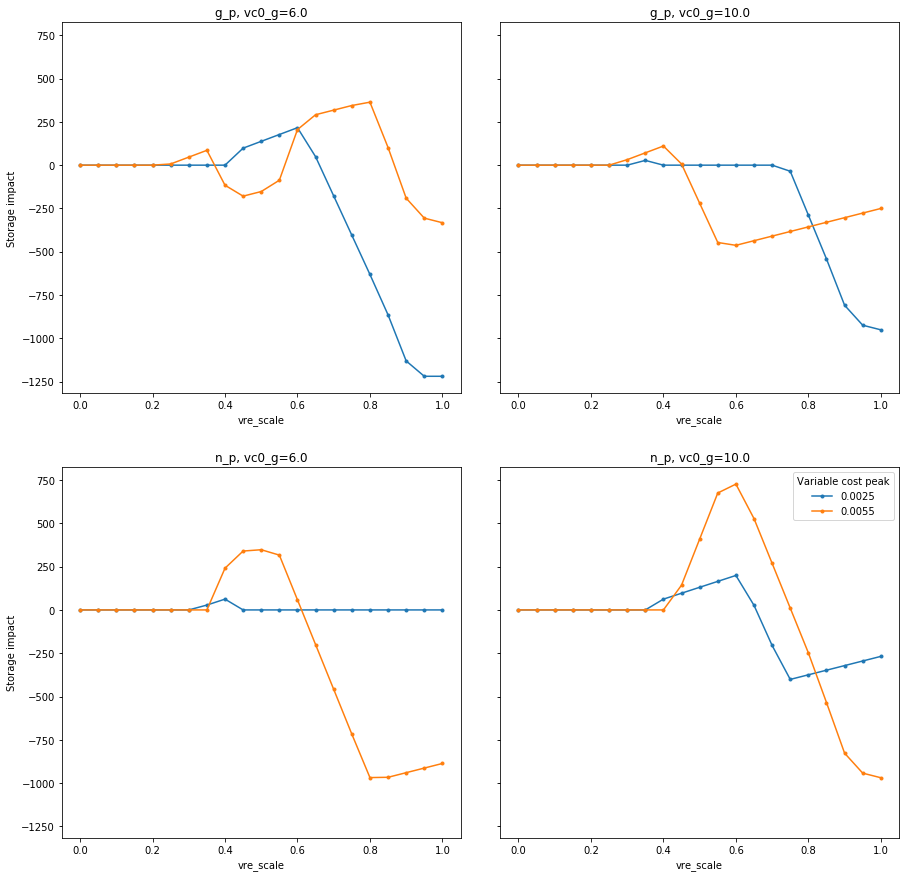

In [16]:
df = ev.df_exp
df = df.loc[df.func.str.contains('n_p_|g_p_')
           & df.is_optimum.isin([True])
           & -df.slot.isin(['global'])]


dfdiff = df.pivot_table(index=[x for x in ev.x_name if not x in ['E_phs', 'C_phs']] + ['func_no_slot'],
                        values='lambd', columns='C_phs')
dfdiff['diff'] = dfdiff[3250] - dfdiff[0]

dfcc = df.loc[df.C_phs == 3250].set_index(dfdiff.index.names)['const_comb']
dfdiff = dfdiff.reset_index().join(dfcc, on=dfdiff.index.names)

dfpv = dfdiff.pivot_table(index=['func_no_slot', 'vc0_g', 'vre_scale'], values='diff',
                          columns=['vc1_g'])

list_func = dfpv.index.get_level_values('func_no_slot').unique()
list_vc0_g = dfpv.index.get_level_values('vc0_g').unique()

fig, axarr = plt.subplots(len(list_func),
                          len(list_vc0_g), sharey=True, gridspec_kw={'wspace': 0.1,}, figsize=(15,15),
                         squeeze=False)

for nfunc, func in enumerate(list_func):
    for nvc0_g, vc0_g in enumerate(list_vc0_g):
        
        ax = axarr[nfunc][nvc0_g] if isinstance(axarr, np.ndarray) else axarr
        dfpv.loc[(func, vc0_g)].plot(ax=ax, legend=False, marker='.',use_index=True, stacked=False, width=1)
        
        ax.set_title('%s, vc0_g=%s'%(func, vc0_g))
        ax.set_ylabel('Storage impact')
        
leg = ax.legend(title='Variable cost peak')